# Extended Data Fig 3

## Setup

In [5]:
# Set working directory
%cd notebooks
# Autoreload
%load_ext autoreload
%autoreload 2
# Use rpy2 to run R in python notebook for plotting
%load_ext rpy2.ipython

/home/jovyan/work/notebooks
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [2]:
# Import local code
import sys
sys.path.append('/home/jovyan/work/code')
from gradientVersion import *
from processing import *
from analysis_helpers import *
from gandal_validation import *

In [9]:
%%R 
source("../code/fig_extended_3.R")

In [10]:
dme_3d_ds5 = gradientVersion().fit('hcp_3d_ds5')

New gradients version: method=dm, kernel=normalized_angle, sparsity=0, data=hcp_3d_ds5


### Read data using R

In [11]:
%%R
gandal_data <- load("../data/gandal2022_asd/Gene_NormalizedExpression_Metadata_wModelMatrix.RData")
gandal_regressed <- load("../data/gandal2022_asd/Gene_NormalizedExpression_TechnicalCovariatesRemoved.RData")
head(gandal_data)
# datMeta %>% colnames

[1] "datExpr"          "datMeta"          "datMeta_model"    "datSeq"          
[5] "datSeq_numeric"   "rsem_gene_effLen"


In [12]:
%%R
datMeta %>% group_by(Dx, region) %>% summarize(n=n(), n_donor = n_distinct(subject)) %>% 
print(n=30)

`summarise()` has grouped output by 'Dx'. You can override using the `.groups`
argument.
# A tibble: 22 × 4
# Groups:   Dx [2]
   Dx    region         n n_donor
   <fct> <fct>      <int>   <int>
 1 CTL   BA17          28      28
 2 CTL   BA20-37       26      26
 3 CTL   BA24          18      18
 4 CTL   BA3-1-2-5     26      23
 5 CTL   BA38          18      17
 6 CTL   BA39-40       32      32
 7 CTL   BA4-6         28      27
 8 CTL   BA41-42-22    50      33
 9 CTL   BA44-45       20      19
10 CTL   BA7           29      29
11 CTL   BA9           66      45
12 ASD   BA17          36      35
13 ASD   BA20-37       31      29
14 ASD   BA24          35      35
15 ASD   BA3-1-2-5     37      37
16 ASD   BA38          31      31
17 ASD   BA39-40       37      37
18 ASD   BA4-6         36      36
19 ASD   BA41-42-22    72      49
20 ASD   BA44-45       34      32
21 ASD   BA7           41      40
22 ASD   BA9           77      49


In [13]:
%%R
head(gandal_regressed)
gandal_meta <- datMeta
gandal <- datExpr.reg %>% as.data.frame
# rownames(gandal)

In [14]:
%R -o gandal -o gandal_meta
gandal.shape

(24836, 808)

How many subjects in each region?

In [15]:
(gandal_meta
 .loc[lambda x: x['RIN']>=3]
 .groupby(['region', 'Dx']).agg({'subject':'nunique'})
 .unstack(1)
 .T
)

region       BA17  BA20-37  BA24  BA3-1-2-5  BA38  BA39-40  BA4-6  BA41-42-22  \
        Dx                                                                      
subject CTL    21       23    17         21    15       28     27          32   
        ASD    30       29    31         33    28       32     30          44   

region       BA44-45  BA7  BA9  
        Dx                      
subject CTL       19   26   45  
        ASD       31   36   47

How many regions per subject?

In [16]:
(gandal_meta
 .loc[lambda x: x['RIN']>=3]
 .groupby(['subject', 'Dx']).agg({'region':'nunique'})
 .loc[lambda x: x['region']!=0]
 .reset_index(level=0, drop=True)
 .groupby('Dx').describe()
)

region                                               
     count      mean       std  min   25%  50%  75%   max
Dx                                                       
CTL   54.0  5.074074  3.255485  1.0  2.00  5.0  8.0  11.0
ASD   58.0  6.396552  3.233268  1.0  3.25  7.0  9.0  11.0

### Clean Gandal data for stable genes

Choose subjects with many high-RIN regions to use for stability test

In [17]:
subjects_for_stability_test = (
    gandal_meta
    .loc[lambda x: x['RIN']>=3]
    .loc[lambda x: x['Diagnosis']=='CTL']
    .groupby('subject').agg({'region':'nunique'}).loc[lambda x: x['region']>=10].index
)
subjects_for_stability_test.shape

(6,)

In [18]:
genes_to_keep = get_stable_genes(gandal, gandal_meta, subjects_for_stability_test)

Filter for controls, stable genes, and RIN 3+ samples

In [19]:
controls = gandal_meta['Diagnosis'] == 'CTL'
RIN_filter = gandal_meta['RIN'] >= 3
age_filter = gandal_meta['Age'] >= 18
gandal_controls = gandal.loc[lambda x: np.isin(x.index, genes_to_keep), controls & RIN_filter].T
# gandal_controls = gandal.loc[lambda x: np.isin(x.index, genes_to_keep), controls & RIN_filter & age_filter].T
# gandal_controls = gandal.loc[:, controls & RIN_filter].T
gandal_controls.shape

(311, 12418)

### Compute group level PCA and test

In [20]:
gandal_meta.loc[controls & RIN_filter, 'Age'].mean()

25.979742765273254

In [21]:
gandal_controls_group = gandal_controls.groupby(gandal_meta['region']).mean()
gandal_pca_markers = ['ENSG00000172345.13_2', 'ENSG00000152894.14_2', 'ENSG00000005884.17_1', 'ENSG00000187323.11_1']
pca_gandal_group = gradientVersion(approach='pca', marker_genes = gandal_pca_markers, n_components=5).fit(gandal_controls_group)

New gradients version: method=pca, kernel=None, sparsity=0, data=(data given)


In [557]:
# dme_gandal_group = gradientVersion(approach='dm', marker_genes = gandal_pca_markers, n_components=5).fit(gandal_controls_group)

New gradients version: method=dm, kernel=normalized_angle, sparsity=0, data=(data given)


Gandal 50% most stable genes, 3+ RIN

Weights

In [22]:
#Swap ensembl IDs to gene symbols
gene_symbol_matches = ensembl_id_to_gene_symbol(pca_gandal_group.weights.index)

In [23]:
pca_gandal_weights = (
    pca_gandal_group.fit_weights(n_components=5)
    .assign(ensembl = lambda x: [y[0] for y in x.index.str.split('.')])
    .set_index('ensembl')
    .join(gene_symbol_matches)
    .groupby('symbol').mean()
)

weights_corr = correlate(pca_gandal_weights, dme_3d_ds5.fit_weights(n_components=5))
weights_corr

,C1,C2,C3,C4,C5
C1,0.873564,-0.096345,0.120518,-0.175762,0.152712
C2,0.162146,0.654310,0.102944,-0.009889,0.139051
C3,0.233941,0.173302,0.245228,0.307805,0.539784
C4,0.062804,-0.077168,0.627138,0.077639,0.126786
C5,0.064822,0.058259,0.115284,-0.245975,0.193952


In [559]:
dme_gandal_weights = (
    dme_gandal_group.fit_weights(n_components=5)
    .assign(ensembl = lambda x: [y[0] for y in x.index.str.split('.')])
    .set_index('ensembl')
    .join(gene_symbol_matches)
    .groupby('symbol').mean()
)

weights_corr = correlate(dme_gandal_weights, dme_3d_ds5.fit_weights(n_components=5))
weights_corr

,C1,C2,C3,C4,C5
C1,0.871875,-0.116676,0.116314,-0.175676,0.154555
C2,0.284140,0.537314,0.298785,0.020613,0.171334
C3,0.185133,0.198936,0.205937,0.316770,0.527598
C4,-0.040985,-0.420085,0.495083,0.150232,0.040000
C5,-0.075114,-0.076799,-0.344569,0.180604,-0.220100


Regions

In [24]:
ahba_mapped = map_ahba_to_gandal_regions(dme_3d_ds5, gandal_meta, n_components=5)

pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Downloaded 5046272 of 5482474 bytes (92.0%,    0.1s remaining) ...done. (3 seconds, 0 min)
Extracting data from /home/jovyan/neuromaps-data/599046a594e0e45c04e90291c2348cbe/fsLR32k.tar.gz..... done.


Downloaded 25870336 of 26561319 bytes (97.4%,    0.1s remaining) ...done. (5 seconds, 0 min)
Extracting data from /home/jovyan/neuromaps-data/030343e2c52d5517d71ab63dbec6a5ae/fsaverage164k.tar.gz..... done.


In [25]:
pca_gandal_scores = (pca_gandal_group.clean_scores(n_components=5)
 .drop('label', axis=1)
 .rename_axis('region')
)
scores_corr = correlate(pca_gandal_scores, ahba_mapped.unstack(1).droplevel(0, axis=1))
scores_corr

,C1,C2,C3,C4,C5
C1,0.850831,-0.494109,-0.288615,-0.537058,0.562934
C2,0.384492,0.748501,0.067746,0.067870,-0.183106
C3,0.204010,-0.077310,-0.372266,0.529690,-0.186593
C4,0.064073,0.124799,0.732852,0.227381,-0.579056
C5,0.058896,0.256682,-0.188098,-0.516889,0.421218


In [26]:
dme_gandal_scores = (dme_gandal_group.clean_scores(n_components=5)
 .drop('label', axis=1)
 .rename_axis('region')
)
scores_corr = correlate(dme_gandal_scores, ahba_mapped.unstack(1).droplevel(0, axis=1))
scores_corr

NameError: name 'dme_gandal_group' is not defined

### Plot heatmap

In [27]:
def melt_corrs(corrs):
    return (corrs
     .melt(ignore_index=False)
     .reset_index()
     .set_axis(['gandal_C', 'ahba_C', 'r'], axis=1)
    )

weights_heatmap = melt_corrs(weights_corr)
scores_heatmap = melt_corrs(scores_corr)

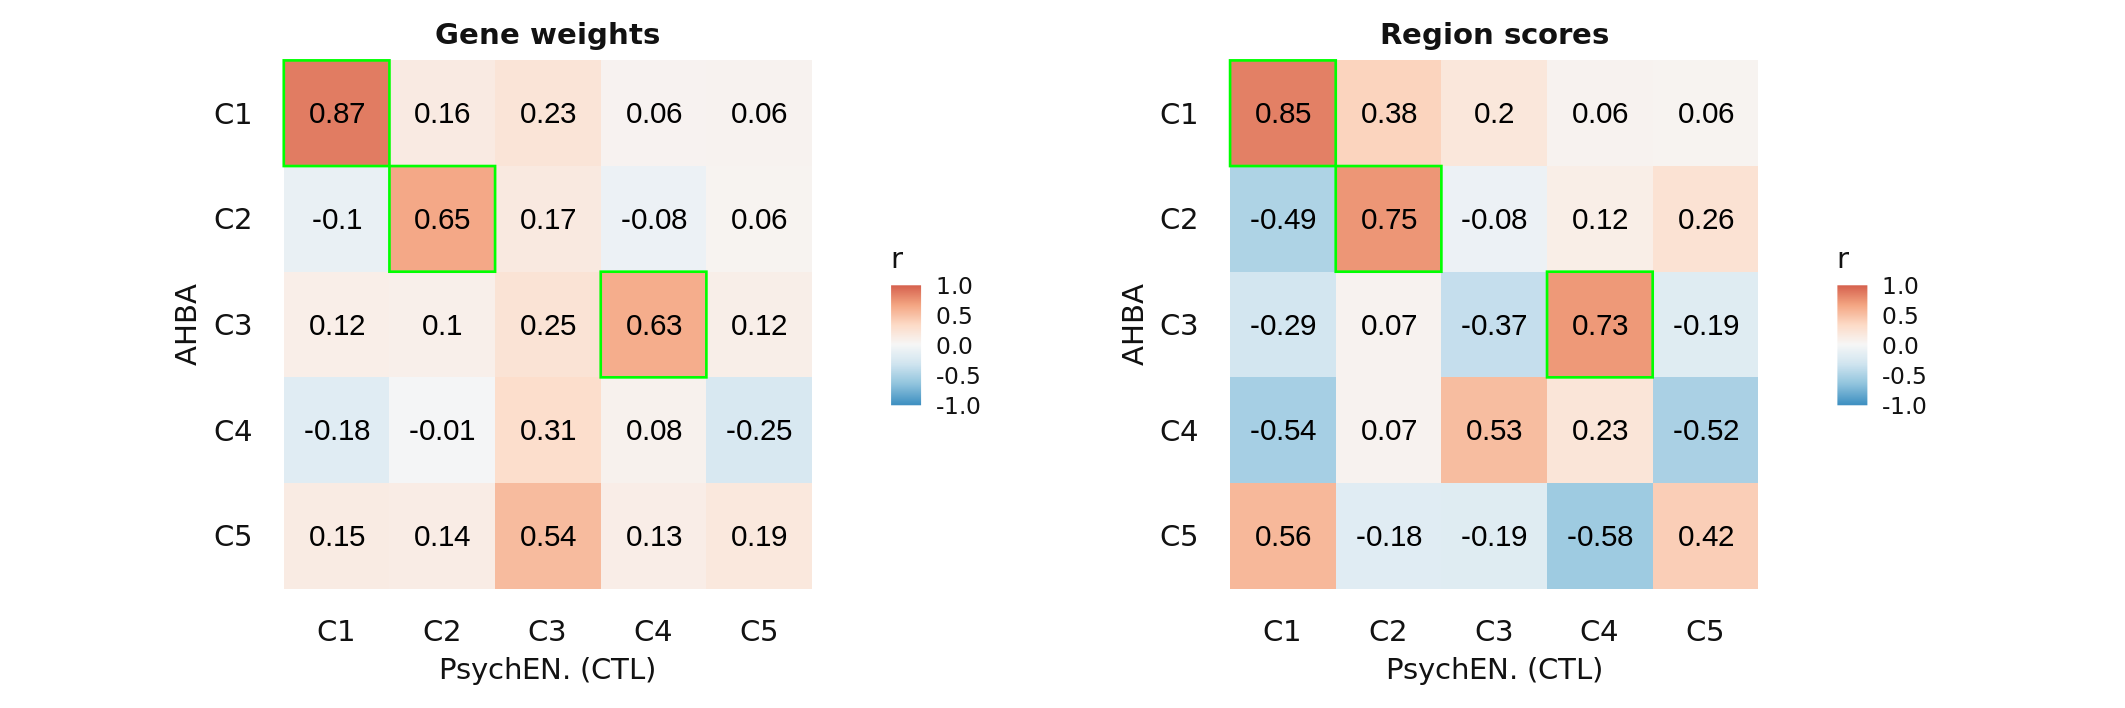

In [30]:
%%R -w 180 -h 60 -u mm -r 300 -i weights_heatmap -i scores_heatmap
source("../code/fig_extended_3.R")

g_heatmaps <- ((
    plot_heatmap(weights_heatmap, title = 'Gene weights') + 
    plot_heatmap(scores_heatmap, title = 'Region scores')
    # plot_layout(guides = 'collect') 
) & theme(legend.position='right'))
g_heatmaps

In [32]:
dict_var_exp = {
    'AHBA': get_var_explained(dme_3d_ds5),
    'PsychEN.': get_var_explained_from_eigenvalues(pca_gandal_group)
}

df_var_exp = (pd.DataFrame(dict_var_exp, index=[f'C{i+1}' for i in range(5)])
              .rename_axis('C').reset_index()
              .melt(id_vars='C', var_name='which', value_name='pct'))
df_var_exp.tail()

,C,which,pct
5,C1,PsychEN.,0.503396
6,C2,PsychEN.,0.133293
7,C3,PsychEN.,0.097583
8,C4,PsychEN.,0.071242
9,C5,PsychEN.,0.052110


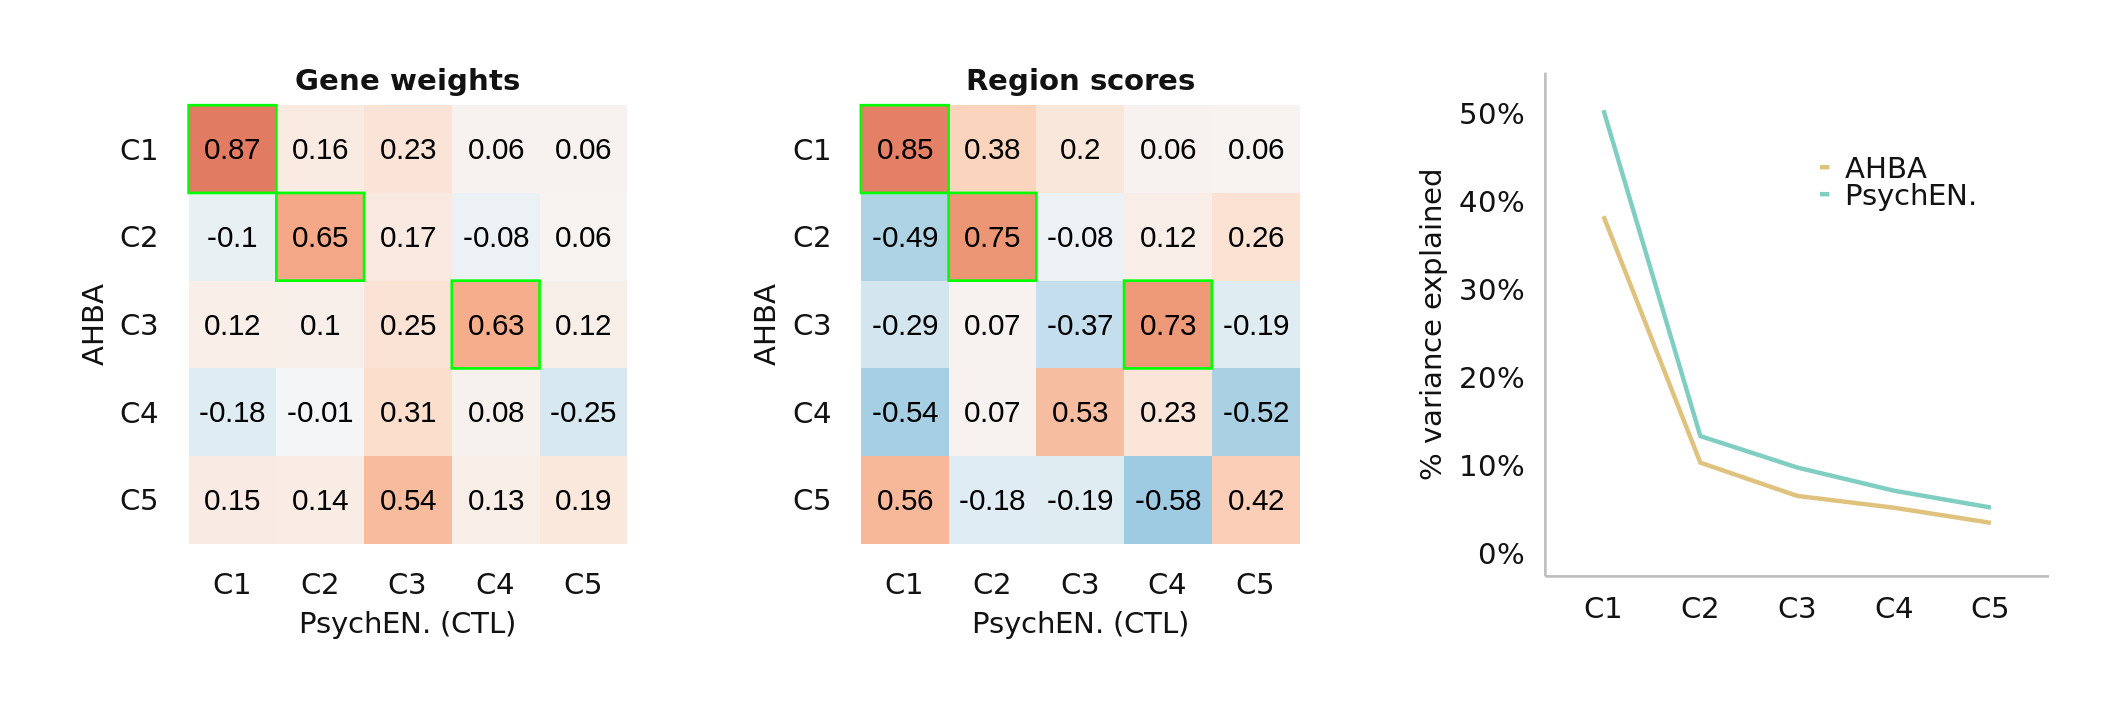

In [34]:
%%R -w 180 -h 60 -u mm -r 300 -i weights_heatmap -i scores_heatmap -i df_var_exp
source("../code/fig_extended_3.R")

g_heatmaps <- ((
    plot_heatmap(weights_heatmap, title = 'Gene weights') + 
    plot_heatmap(scores_heatmap, title = 'Region scores')
) & theme(legend.position='none'))

g_scree <- plot_scree(df_var_exp)

(g_heatmaps | g_scree) + plot_layout(widths=c(2,1))

### Testing other variants

AHBA genes, all RIN

In [545]:
(gandal_test_agg.clean_scores(n_components=5).drop('label', axis=1)
 .assign(brodmann = lambda x: x.index.str.strip('BA').str.split('-'))
 .explode('brodmann')
 .reset_index()
 .join(ahba_brodmann.set_index('brodmann'), on='brodmann', rsuffix='ahba')
 .drop('index', axis=1)
 .groupby('id').mean()
 .corr().iloc[:5, 5:]
)

,C1ahba,C2ahba,C3ahba
C1,0.870121,-0.485864,-0.298802
C2,-0.384220,-0.738803,0.021416
C3,-0.101987,0.260649,0.330250
C4,-0.064101,-0.121447,-0.688658
C5,-0.004093,-0.145498,0.199171


AHBA genes, 5+ RIN

In [606]:
(gandal_test_agg.clean_scores(n_components=5).drop('label', axis=1)
 .assign(brodmann = lambda x: x.index.str.strip('BA').str.split('-'))
 .explode('brodmann')
 .reset_index()
 .join(ahba_brodmann.set_index('brodmann'), on='brodmann', rsuffix='ahba')
 .drop('index', axis=1)
 .groupby('id').mean()
 .corr().iloc[:5, 5:]
)

,C1ahba,C2ahba,C3ahba
C1,0.861504,-0.453715,-0.307041
C2,-0.219228,-0.722151,-0.190092
C3,0.306703,0.279910,-0.163508
C4,-0.070347,-0.148143,-0.741857
C5,-0.019412,-0.225000,0.254734


All genes, 5+ RIN

In [612]:
(gandal_test_agg.clean_scores(n_components=5).drop('label', axis=1)
 .assign(brodmann = lambda x: x.index.str.strip('BA').str.split('-'))
 .explode('brodmann')
 .reset_index()
 .join(ahba_brodmann.set_index('brodmann'), on='brodmann', rsuffix='ahba')
 .drop('index', axis=1)
 .groupby('id').mean()
 .corr().iloc[:5, 5:]
)

,C1ahba,C2ahba,C3ahba
C1,0.862007,-0.432440,-0.288272
C2,-0.109460,-0.637890,-0.284717
C3,0.372187,0.412859,-0.135225
C4,-0.088462,-0.186702,-0.638439
C5,-0.039222,-0.215880,0.448867


Gandal 50% most stable genes, 5+ RIN

In [673]:
(gandal_test_agg.clean_scores(n_components=5).drop('label', axis=1)
 .assign(brodmann = lambda x: x.index.str.strip('BA').str.split('-'))
 .explode('brodmann')
 .reset_index()
 .join(ahba_brodmann.set_index('brodmann'), on='brodmann', rsuffix='ahba')
 .drop('index', axis=1)
 .groupby('id').mean()
 .corr().iloc[:5, 5:]
)

,C1ahba,C2ahba,C3ahba
C1,0.857365,-0.452661,-0.282684
C2,-0.187552,-0.693635,-0.217815
C3,0.337299,0.333178,-0.249548
C4,-0.083861,-0.191748,-0.685778
C5,-0.030574,-0.198858,0.380040


Gandal 50% most stable genes, all RIN

In [687]:
(gandal_test_agg.clean_scores(n_components=5).drop('label', axis=1)
 .assign(brodmann = lambda x: x.index.str.strip('BA').str.split('-'))
 .explode('brodmann')
 .reset_index()
 .join(ahba_brodmann.set_index('brodmann'), on='brodmann', rsuffix='ahba')
 .drop('index', axis=1)
 .groupby('id').mean()
 .corr().iloc[:5, 5:]
)

,C1ahba,C2ahba,C3ahba
C1,0.857662,-0.501540,-0.282284
C2,-0.424951,-0.682891,0.120386
C3,-0.038754,0.367308,0.414276
C4,-0.092416,-0.110745,-0.619678
C5,0.030204,0.177628,-0.191889


Gandal 50% most stable genes, 4+ RIN

In [705]:
(gandal_test_agg.clean_scores(n_components=5).drop('label', axis=1)
 .assign(brodmann = lambda x: x.index.str.strip('BA').str.split('-'))
 .explode('brodmann')
 .reset_index()
 .join(ahba_brodmann.set_index('brodmann'), on='brodmann', rsuffix='ahba')
 .drop('index', axis=1)
 .groupby('id').mean()
 .corr().iloc[:5, 5:]
)

,C1ahba,C2ahba,C3ahba
C1,0.857801,-0.437549,-0.294324
C2,-0.212869,-0.755480,-0.144792
C3,0.337075,0.209764,-0.302694
C4,-0.114121,-0.203723,-0.711770
C5,0.015800,-0.174257,0.283004


### Plot on brains in brodmann

In [35]:
gandal_dx = (gandal
    .loc[lambda x: np.isin(x.index, genes_to_keep), RIN_filter]
    .groupby(level=0).mean()
).T
gandal_dx.shape

(725, 12418)

In [36]:
# matched_genes = np.intersect1d(dme_3d_ds5.weights.index, gandal_dx.columns)

gandal_dx_projected = (
    (gandal_dx @ pca_gandal_group.fit_weights(n_components=5))
    .loc[:, ['C1','C2','C4']]
    .rename({'C4':'C3'}, axis=1)
    .join(gandal_meta.loc[:, ['subject', 'Dx', 'region']])
    .groupby(['region', 'Dx']).mean().dropna()
    # .apply(lambda x: (x-np.mean(x, axis=0))/np.std(x))
    .melt(ignore_index=False, var_name='C', value_name='projected')
    .reset_index()
    .join(ahba_mapped.query("C in ['C1','C2','C3']"), on=['region', 'C'], how='outer')
    .replace({'C': {'C3':'C3 (AHBA) / C4 (PsychEN.)'}})
)
gandal_dx_projected

,region,Dx,C,projected,ahba_score
0,BA17,CTL,C1,6946.265169,2.111568
1,BA17,ASD,C1,5264.190921,2.111568
2,BA20-37,CTL,C1,3987.519498,-0.574594
3,BA20-37,ASD,C1,3744.463233,-0.574594
4,BA24,CTL,C1,3620.731158,-0.823663
...,...,...,...,...,...
61,BA44-45,ASD,C3 (AHBA) / C4 (PsychEN.),1453.821639,0.721636
62,BA7,CTL,C3 (AHBA) / C4 (PsychEN.),1634.526478,0.456309
63,BA7,ASD,C3 (AHBA) / C4 (PsychEN.),1391.438331,0.456309
64,BA9,CTL,C3 (AHBA) / C4 (PsychEN.),1679.054450,0.645701


In [37]:
gandal_dx_projected_plot = (
    gandal_dx_projected
    .assign(region = lambda x: x['region'].str.strip('BA').str.split('-'))
    .explode('region')
    .assign(region = lambda x: 'BA' + x['region'])
    .set_index(['Dx','C','region'])
    .groupby(['C']).apply(lambda x: (x-np.mean(x.query("Dx == 'CTL'"), axis=0))/np.std(x.query("Dx == 'CTL'")))
    .set_axis(['PsychEN.', 'AHBA'], axis=1)
    .melt(ignore_index=False, var_name = 'version', value_name = 'score')
    .reset_index()
    .sort_values(['version','region', 'Dx'])
    # .sort_values('version')
    .assign(version = lambda x: np.where(x['version'] == 'AHBA', 'AHBA',
                                         x['version'].astype('str') + '\n(' + x['Dx'].astype('str') + ')'))
    .loc[lambda x: ~((x['Dx'] == 'ASD') & (x['version'] == 'AHBA'))]
    .dropna()
)
gandal_dx_projected_plot

,Dx,C,region,version,score
129,CTL,C1,BA1,AHBA,0.962870
169,CTL,C2,BA1,AHBA,0.016607
209,CTL,C3 (AHBA) / C4 (PsychEN.),BA1,AHBA,-0.858577
120,CTL,C1,BA17,AHBA,2.161170
160,CTL,C2,BA17,AHBA,-2.299659
...,...,...,...,...,...
78,CTL,C2,BA9,PsychEN.\n(CTL),0.531025
118,CTL,C3 (AHBA) / C4 (PsychEN.),BA9,PsychEN.\n(CTL),0.613746
39,ASD,C1,BA9,PsychEN.\n(ASD),-0.718258
79,ASD,C2,BA9,PsychEN.\n(ASD),-0.582350


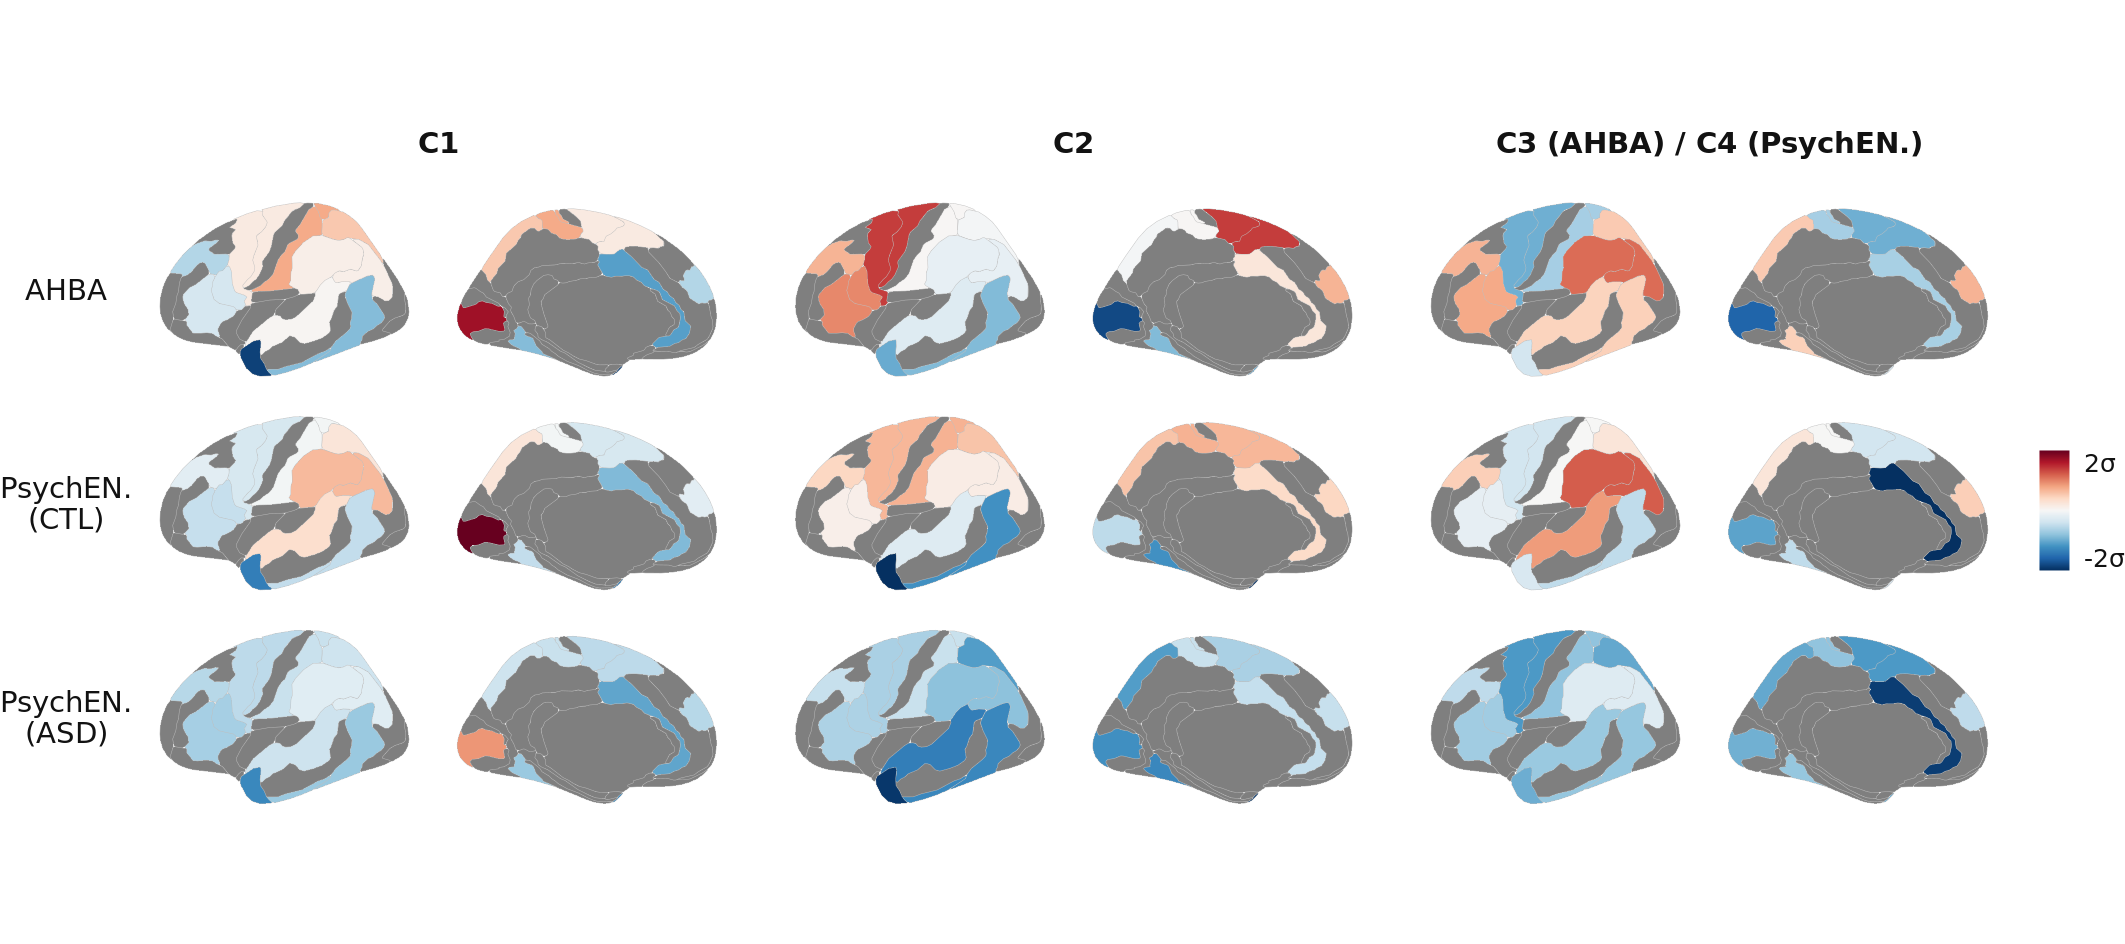

In [39]:
%%R -w 180 -h 80 -u mm -r 300 -i gandal_dx_projected_plot
source("../code/fig_extended_3.R")

g_brains <- gandal_dx_projected_plot %>% plot_brains_brodmann
g_brains

### Individual subject projections

Take only subjects with at least 5 regions (with RIN 3+)?

In [40]:
subjects_for_projection = (gandal_meta
    .loc[lambda x: x['RIN'] >= 3]
    .groupby(['subject', 'Dx']).agg({
        'region':['nunique', lambda x: max(x=='BA17')]})
    .set_axis(['n_regions', 'includes_BA17'], axis=1)
    .loc[lambda x: x['n_regions'] >= 5]
    # .loc[lambda x: x['includes_BA17'] == True]
    .reset_index()
) 
# subjects_for_projection
subjects_for_projection['Dx'].value_counts()

ASD    39
CTL    29
Name: Dx, dtype: int64

In [41]:
RIN_filter = gandal_meta['RIN'] >= 3
subject_region_filter = np.isin(gandal_meta['subject'], subjects_for_projection['subject'])
gandal_subjects = (gandal
    .loc[lambda x: np.isin(x.index, genes_to_keep), subject_region_filter & RIN_filter]
    .groupby(level=0).mean()
).T
gandal_subjects.shape

(633, 12418)

In [42]:
ahba_mapped = map_ahba_to_gandal_regions(dme_3d_ds5, gandal_meta, n_components=3)
ahba_mapped.head()

pixdim[1,2,3] should be non-zero; setting 0 dims to 1


,,ahba_score
region,C,
BA17,C1,2.111568
BA20-37,C1,-0.574594
BA24,C1,-0.823663
BA3-1-2-5,C1,1.124557
BA38,C1,-1.628578


In [43]:
# matched_genes = np.intersect1d(dme_3d_ds5.weights.index, gandal_subjects.columns)

gandal_subjects_projected = (
    (gandal_subjects @ pca_gandal_group.fit_weights(n_components=5))
    .loc[:, ['C1','C2','C4']]
    # .rename({'C4':'C3'}, axis=1)
    .join(gandal_meta.loc[:, ['subject', 'Dx', 'region']])
    .groupby(['subject', 'region', 'Dx']).mean().dropna()
    # .apply(lambda x: (x-np.mean(x, axis=0))/np.std(x))
    .melt(ignore_index=False, var_name='C', value_name='projected')
    .set_index('C', append=True)
    .groupby(['C']).apply(lambda x: (x-np.mean(x.query("Dx == 'CTL'"), axis=0))/np.std(x.query("Dx == 'CTL'")))
    .reset_index()
    # .join(ahba_mapped, on=['region', 'C'], how='outer')
    # .replace({'C': {'C3':'C3 (AHBA) / C4 (PsychEN.)'}})
)
gandal_subjects_projected

,subject,region,Dx,C,projected
0,AN00493,BA17,ASD,C1,-0.980083
1,AN00493,BA20-37,ASD,C1,-2.286345
2,AN00493,BA24,ASD,C1,-2.156760
3,AN00493,BA4-6,ASD,C1,-1.834585
4,AN00493,BA41-42-22,ASD,C1,-0.904237
...,...,...,...,...,...
1660,UMB5340,BA4-6,ASD,C4,0.092933
1661,UMB5340,BA41-42-22,ASD,C4,0.422216
1662,UMB5340,BA44-45,ASD,C4,-0.379798
1663,UMB5340,BA7,ASD,C4,-0.104927


In [44]:
from scipy import stats
from statsmodels.stats.multitest import multipletests 

gandal_region_stats = (gandal_subjects_projected
 .groupby(['C', 'region'])
 .apply(lambda x: stats.ttest_ind(x.query("Dx=='CTL'")['projected'], x.query("Dx=='ASD'")['projected']))
 .apply(pd.Series, index=['t','p'])
 .assign(q = lambda x: multipletests(x['p'], method='fdr_bh')[1])
 .reset_index()
)
gandal_region_stats.head()

,C,region,t,p,q
0,C1,BA17,4.464429,0.000055,0.000456
1,C1,BA20-37,0.397533,0.692854,0.737554
2,C1,BA24,0.774334,0.442695,0.541072
3,C1,BA3-1-2-5,1.399255,0.167910,0.263858
4,C1,BA38,0.668716,0.508063,0.578141


`summarise()` has grouped output by 'C'. You can override using the `.groups`
argument.


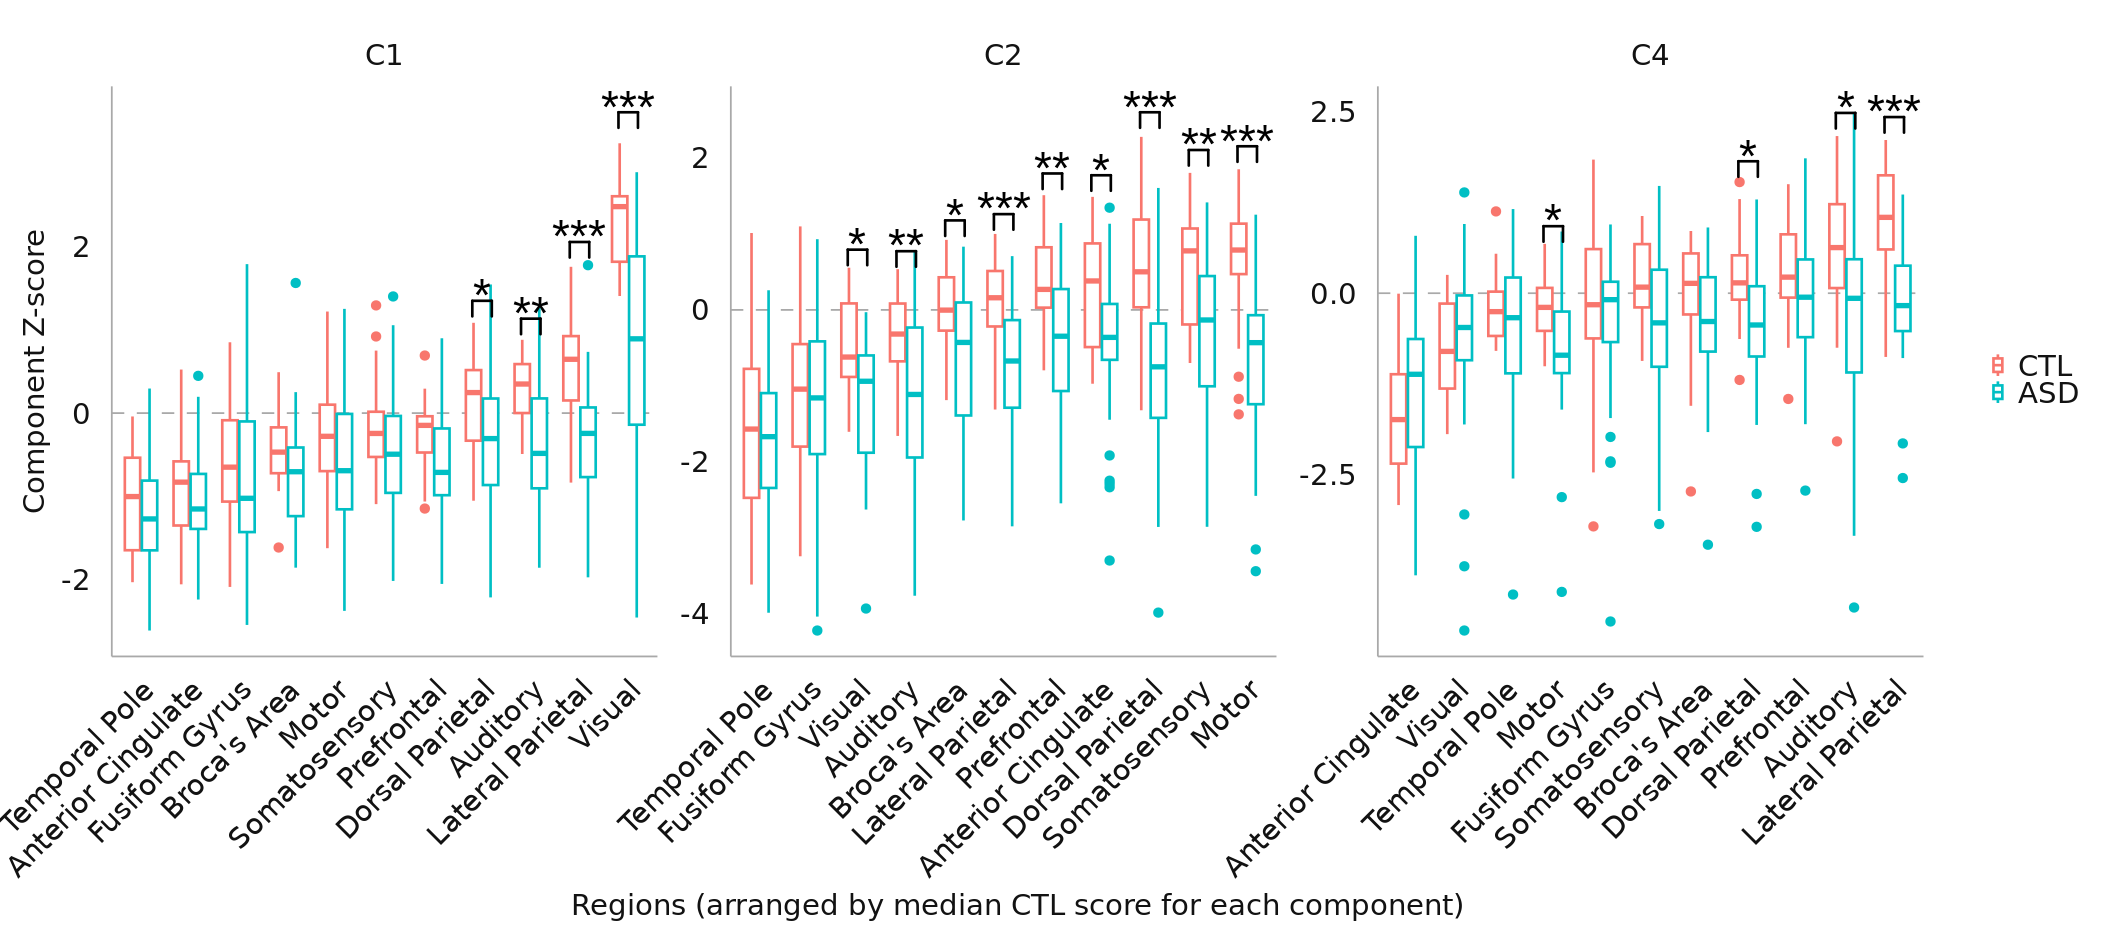

In [45]:
%%R -w 180 -h 80 -u mm -r 300 -i gandal_subjects_projected -i gandal_region_stats
source("../code/fig_extended_3.R")

plot_gandal_boxplots(gandal_subjects_projected, gandal_region_stats)

### Combine plots

`summarise()` has grouped output by 'C'. You can override using the `.groups`
argument.


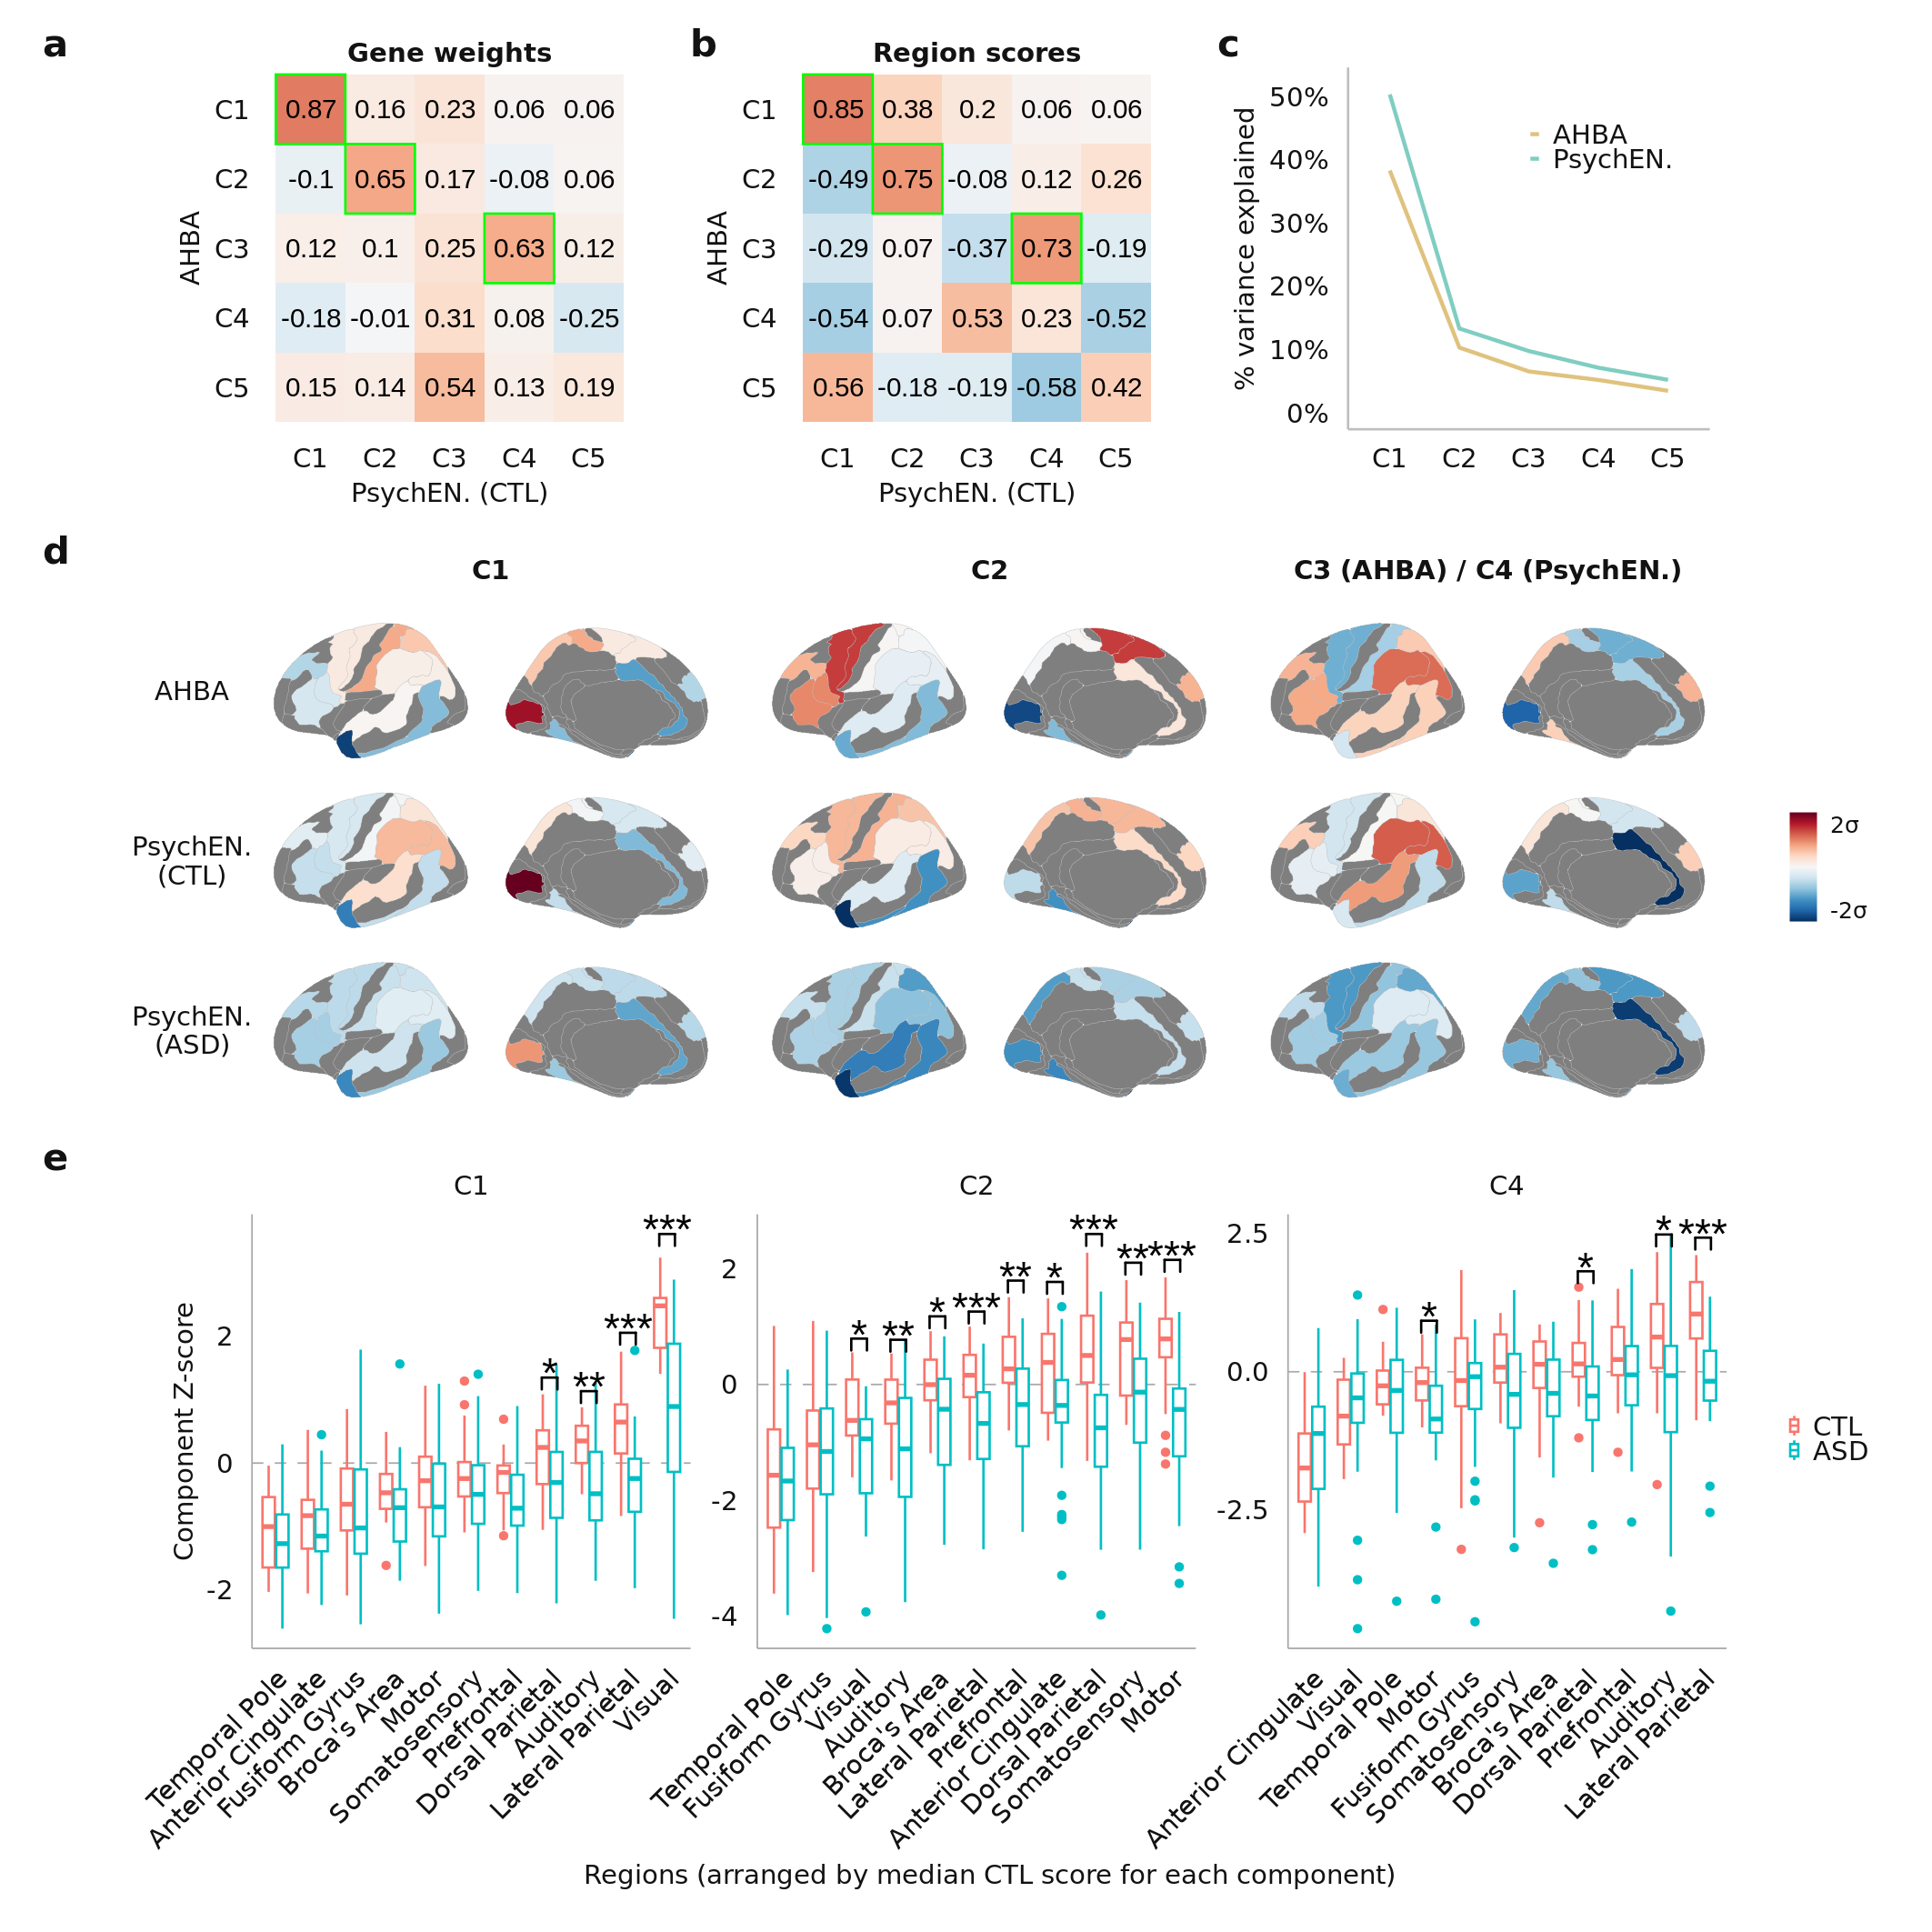

In [47]:
%%R -w 180 -h 180 -u mm -r 300 -i gandal_subjects_projected -i gandal_region_stats

design <- c(
  # area(t = 1, b = 50, l = 1, r = 90),
  # area(t = 1, b = 50, l = 91, r = 180),
  area(t = 1, b = 50, l = 1, r = 60),
  area(t = 1, b = 50, l = 61, r = 120),
  area(t = 1, b = 50, l = 121, r = 180),
  area(t = 51, b = 120, l = 1, r = 180),
  area(t = 121, b = 180, l = 1, r = 180)
)

g_boxplots <- plot_gandal_boxplots(gandal_subjects_projected, gandal_region_stats) +
  theme(axis.title.y = element_text(margin = margin(0,-15,0,0,'mm')))

plot <- g_heatmaps + g_scree + g_brains + g_boxplots + plot_layout(design=design)

themed <- plot & theme(plot.margin = margin(t=2, b=2, l=2, r=2, unit='mm'))
annotated <- themed + plot_annotation(tag_level='a')
annotated

In [48]:
%%R
ggsave(file="../outputs/figures/fig_ext_3.svg", plot=annotated, width=180, height=180, units='mm')

### Old lines plot

In [ ]:
%%R -w 180 -h 60 -u mm -r 300 -i gandal_subjects_projected -i gandal_dx_projected
source("../code/fig_extended_3.R")
g_lines <- plot_gandal_lines(gandal_dx_projected, gandal_subjects_projected)
g_lines

  could not find function "geom_text_repel"


   C      version atlas type  hemi  side  region label roi   annot Dx      score
   <chr>  <fct>   <chr> <chr> <chr> <chr> <chr>  <chr> <chr> <chr> <fct>   <dbl>
 1 C1     AHBA    <NA>  <NA>  <NA>  <NA>  BA1    <NA>  <NA>  <NA>  CTL    0.963 
 2 C1     AHBA    <NA>  <NA>  <NA>  <NA>  BA3    <NA>  <NA>  <NA>  CTL    0.963 
 3 C1     AHBA    <NA>  <NA>  <NA>  <NA>  BA41   <NA>  <NA>  <NA>  CTL    0.0462
 4 C1     AHBA    <NA>  <NA>  <NA>  <NA>  BA42   <NA>  <NA>  <NA>  CTL    0.0462
 5 C2     AHBA    <NA>  <NA>  <NA>  <NA>  BA1    <NA>  <NA>  <NA>  CTL    0.0166
 6 C2     AHBA    <NA>  <NA>  <NA>  <NA>  BA3    <NA>  <NA>  <NA>  CTL    0.0166
 7 C2     AHBA    <NA>  <NA>  <NA>  <NA>  BA41   <NA>  <NA>  <NA>  CTL   -0.329 
 8 C2     AHBA    <NA>  <NA>  <NA>  <NA>  BA42   <NA>  <NA>  <NA>  CTL   -0.329 
 9 C3 (A… AHBA    <NA>  <NA>  <NA>  <NA>  BA1    <NA>  <NA>  <NA>  CTL   -0.859 
10 C3 (A… AHBA    <NA>  <NA>  <NA>  <NA>  [... truncated] 




Error in geom_text_repel(aes(label = region), data = df_labels, min.segment.length = 0.1,  : 
  could not find function "geom_text_repel"


RInterpreterError: Failed to parse and evaluate line 'source("../code/fig_extended_3.R")\ng_lines <- plot_gandal_lines(gandal_dx_projected, gandal_subjects_projected)\ng_lines\n'.
R error message: 'Error in geom_text_repel(aes(label = region), data = df_labels, min.segment.length = 0.1,  : \n  could not find function "geom_text_repel"'

### Project AHBA C1-3 into brodmann regions

In [1032]:
from neuromaps.transforms import fslr_to_fsaverage
from neuromaps.images import dlabel_to_gifti, relabel_gifti
from neuromaps.nulls.spins import parcels_to_vertices, vertices_to_parcels

In [1034]:
ahba_brodmann = project_ahba_to_brodmann(dme_3d_ds5)

pixdim[1,2,3] should be non-zero; setting 0 dims to 1


In [ ]:
brodmann = nib.load("../data/parcellations/Human.Brodmann09.32k_fs_LR.dlabel.nii")

pixdim[1,2,3] should be non-zero; setting 0 dims to 1


In [ ]:
brodmann_fslr = dlabel_to_gifti("../data/parcellations/Human.Brodmann09.32k_fs_LR.dlabel.nii")
brodmann_fsa = fslr_to_fsaverage(brodmann_gifti, target_density='164k', hemi='L', method='nearest')

pixdim[1,2,3] should be non-zero; setting 0 dims to 1


In [ ]:
np.unique(brodmann_fsa_relabel[0].agg_data())

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42])

In [ ]:
# brodmann.header.mapped_indices
# dir(brodmann)
print(brodmann.header.from_header())

In [ ]:
np.unique(brodmann.get_fdata())

array([ 0.,  1., 54., 55., 56., 57., 58., 59., 60., 61., 62., 63., 64.,
       65., 66., 67., 68., 69., 70., 71., 72., 73., 74., 75., 76., 77.,
       78., 79., 80., 81., 82., 83., 84., 85., 86., 87., 88., 89., 90.,
       91., 92., 93., 94.])

In [ ]:
brodmann_labels = brodmann_fslr[0].labeltable.get_labels_as_dict()
brodmann_labels = (
    pd.Series(brodmann_labels).str.split('_').str[0]
    .to_frame('brodmann')
    .reset_index()
)
brodmann_labels

# Using cifti file instead of converting to gifti
# brodmann_labels = brodmann.header.get_axis(0).label[0]
# (pd.Series({k:v[0] for k,v in brodmann_labels.items()})
#  .loc[54:94]    
#  .str.split('_').str[0]
# )

,index,brodmann
0,0,???
1,1,MEDIAL.WALL
2,54,8
3,55,6
4,56,4
5,57,9
6,58,3
7,59,1
8,60,5
9,61,7


In [ ]:
brodmann_fsa_relabel = relabel_gifti(brodmann_fsa, background=0)

In [ ]:
from neuromaps.nulls.spins import parcels_to_vertices, vertices_to_parcels
hcp_img = "../data/parcellations/lh.HCPMMP1.annot"
hcp_img = annot_to_gifti(hcp_img)

c_brodmann = {}
for i in range(3):
    c_hcp = dme_3d_ds5.clean_scores().reindex(range(1,181)).iloc[:, i]
    c_fsa = parcels_to_vertices(c_hcp, hcp_img)
    c_brodmann[i] = vertices_to_parcels(c_fsa, brodmann_fsa_relabel, background=0)

In [ ]:
ahba_brodmann = pd.DataFrame(c_brodmann, index=range(1,43)).set_axis(['C1','C2','C3'], axis=1).join(brodmann_labels)
ahba_brodmann.head()

,C1,C2,C3,index,brodmann
1,-1.709403,-0.465624,-0.379617,1,MEDIAL.WALL
2,-0.148398,1.677675,-0.029372,54,8
3,0.097362,1.830569,-0.604514,55,6
4,0.950296,1.510698,-1.728207,56,4
5,-0.284880,0.844679,0.645583,57,9


### Individual level PCA

In [225]:
gandal_test = gradientVersion(approach='pca', marker_genes = [], n_components=5).fit(gandal_controls)

New gradients version: method=pca, kernel=None, sparsity=0, data=(data given)


In [232]:
correlate(gandal_test.fit_weights(n_components=5).groupby(level=0).mean(), dme_3d_ds5.weights)

,C1,C2,C3
C1,-0.676105,-0.015210,0.188700
C2,-0.370049,-0.039460,-0.557322
C3,0.083204,-0.194556,0.321542
C4,0.392194,-0.226993,-0.285830
C5,0.070686,0.006841,-0.032593


In [233]:
correlate(gandal_test.weights.groupby(level=0).mean(), dme_3d_ds5.weights)

,C1,C2,C3
C1,-0.676105,-0.015210,0.188700
C2,-0.370049,-0.039460,-0.557322
C3,0.083204,-0.194556,0.321542
